In [267]:
from pathlib import Path
import pandas as pd
import json
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


## Preprocessing

In [268]:
def load_evaluation_files(base_folders=None, root_path="."):
    """
    Load all .json files from the 'evaluation' subdirectories of specified folders.

    Args:
        base_folders (list): List of folders to look for (e.g., ['testset1', 'testset3', 'testset4']).
        root_path (str): The root path where the base folders are located (default is the current directory).

    Returns:
        dict: A dictionary where keys are file paths and values are the parsed JSON data.
    """
    all_data = {}
    if base_folders is None:
        base_folders = [folder.name for folder in Path(root_path).iterdir() if folder.is_dir()]
    
    print(base_folders)
    for folder in base_folders:
        eval_path = os.path.join(root_path, folder,"**",  "evaluation","**", "*.json")
        json_files = glob.glob(eval_path, recursive = True)

        for file_path in json_files:
            try:
                with open(file_path, "r") as f:
                    data = json.load(f)
                    all_data[str(file_path)] = {}
                    all_data[str(file_path)]["solution"] = data["solution"]
                    all_data[str(file_path)]["metadata"] = data["metadata"]
                    if "solution_combined" in data.keys():
                        all_data[str(file_path)]["solution_combined"] = data["solution_combined"]
            except Exception as e:
                del all_data[str(file_path)]
                print(f"Error loading {file_path}: {e}")
    
    
    return all_data

In [269]:
def generate_pandas_df(data, online:bool=False):
    for file_path, values in data.items():
        solution = {file_path : values["solution"]}
        metadata = {file_path : values["metadata"]}
        if 'solution_combined' in values.keys():
            solution_combined = {file_path : values["solution_combined"]}
            solution_combined_df = pd.DataFrame.from_dict(solution_combined, orient="index")
        df = pd.DataFrame.from_dict(solution, orient="index")
        meta_df = pd.DataFrame.from_dict(metadata, orient="index")
        
        df = pd.concat([df, meta_df], axis=1)

    df = pd.DataFrame.from_dict(data, orient="index")
    solution_norm = pd.json_normalize(df["solution"]).set_index(df.index)
    metadata_norm = pd.json_normalize(df["metadata"]).set_index(df.index)

    # combine the two normalized dfs
    df_normalized = df.drop(["solution", "metadata"], axis=1)\
                    .join(solution_norm, rsuffix='_sol')\
                    .join(metadata_norm, rsuffix='_meta')
    df_normalized.reset_index(inplace=True)
    df_normalized['config_name'] = df_normalized["index"].apply(lambda x: x.split('/')[1]) + df_normalized["index"].apply(lambda x: x.split('/')[-1])
    df_normalized["solution_type"] = df_normalized["index"].apply(lambda x: x.split('/')[-2])
    df_normalized.set_index('index', inplace=True)

    if online: 
        solution_combined_df = pd.json_normalize(df["solution_combined"]).set_index(df.index)
        return df_normalized, solution_combined_df
    else:
        return df_normalized

def pre_process_df(df:pd.DataFrame):
    df["set_ident"] =  df.groupby(["config_name"]).ngroup() + 1
    
    df = df.sort_values(by=['config_name', 'objective'])

    # Calculate the absolute difference to best performing allocation: 
    df_shortened = df[['set_ident', 'solution_type', 'objective', 'release_times']]
    df_shortened["min_objective"] = df_shortened.groupby("set_ident")["objective"].transform("min")
    
    # Get heuristic value
    heuristic_df = df_shortened[df_shortened["solution_type"] == "heuristic"][["set_ident", "objective"]]
    heuristic_df = heuristic_df.rename(columns={"objective": "heur_objective"})

    df_shortened.reset_index(inplace=True)
    df_shortened = df_shortened.merge(heuristic_df, on='set_ident', how="left")
    df_shortened.set_index('index', inplace=True)

    # Get enthropy value
    enthropy_df = df[df["solution_type"] == "single_instance_cp"][["set_ident", 'tasks', "enthropy"]]
    df = df.drop(columns=["enthropy"])
    # Normalize entropy for each config_name
    enthropy_df['normalized_entropy'] = enthropy_df[['tasks', "enthropy"]].groupby('tasks')['enthropy'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    enthropy_df['normalized_entropy_all'] = enthropy_df[["enthropy"]].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    df_shortened.reset_index(inplace=True)
    df_shortened = df_shortened.merge(enthropy_df, on='set_ident', how="left")
    df_shortened.set_index('index', inplace=True)

    # Get parallelity value
    parallelity_df = df[df["solution_type"] == "single_instance_cp"][["set_ident", "parallelity"]]
    parallelity_df['parallelity_norm'] = parallelity_df[["parallelity"]].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    df = df.drop(columns=["parallelity"])
    df_shortened.reset_index(inplace=True)
    df_shortened = df_shortened.merge(parallelity_df, on='set_ident', how="left")
    df_shortened.set_index('index', inplace=True)
    
    df_shortened["makespan_deviation"] = df_shortened["objective"] - df_shortened["min_objective"]
    df_shortened["deviation_to_heur"] = df_shortened["objective"] - df_shortened["heur_objective"]


    # Relative makespan deviation
    df_shortened['relative_makespan_deviation'] = df_shortened["makespan_deviation"]/ df_shortened["min_objective"]
    df_shortened['relative_makespan_deviation'] = (df_shortened['relative_makespan_deviation']*100.).round(2)
    
    df_shortened["release_type"] = df_shortened["release_times"].apply(
        lambda x: "arrival" if type(x) is float or len(set(x)) > 1 else "same_release"
    )

    df = df.join(df_shortened[['makespan_deviation', 'relative_makespan_deviation', 'release_type', 'min_objective', 'deviation_to_heur', 'enthropy', 'normalized_entropy', 'normalized_entropy_all', 'parallelity', 'parallelity_norm']])
    # calculate resource standard deviation: 
    cols_to_conv =['resource_importance.res_1', 'resource_importance.res_2', 'resource_importance.res_3', 'resource_importance.res_4']
    df[cols_to_conv] = df[cols_to_conv].astype(float)
    df['res_std_dev'] = df[cols_to_conv].std(axis=1)

    return df

# Offline tests

In [270]:
base_folders=['10_instantArr']
data = load_evaluation_files(base_folders, root_path = "testsets_decomposed_pipe")
print(f"{len(data)} datasets loaded")

['10_instantArr']
18 datasets loaded


In [271]:
df_raw = generate_pandas_df(data, online=False)
df = pre_process_df(df_raw)
df_cp = df[df["solution_type"].str.contains("cp", case=False, na=False)]
df_cp = df_cp.groupby("set_ident")[["lower_bound"]].max().rename(columns={'lower_bound':'best_lower_bound'})
df = df.merge(df_cp, on='set_ident', how="left")
df = df[['config_name', 'solution_type', 'set_ident', 'lower_bound', 'objective', 'best_lower_bound']].set_index('config_name')

/tmp/ipykernel_1288658/2253014233.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shortened["min_objective"] = df_shortened.groupby("set_ident")["objective"].transform("min")


In [272]:
df['lower_bound'] = df['lower_bound'].astype(int)
df['gap'] = (((df['objective'] - df['lower_bound']) / df['objective']) * 100).map(lambda x: f"{x:.1f}%")
df['best_gap'] = (((df['objective'] - df['best_lower_bound']) / df['objective']) * 100).map(lambda x: f"{x:.1f}%")

df["metrics"] = df.apply(lambda row: f"{row['lower_bound']}, {row['objective']}, {row['gap']}", axis=1)

# Pivot the DataFrame to create a multi-indexed structure
df_pivot = df.pivot( columns="solution_type", values=["lower_bound", "objective", "gap", 'best_gap'])

# Rename the first level of columns for clarity
df_pivot.columns.names = [None, "Solution Type"]

# Swap column levels (Solution Type first, then Metric)
df_pivot = df_pivot.swaplevel(0, 1, axis=1)

# Rename metrics to more readable labels
df_pivot = df_pivot.rename(columns={"lower_bound": "0 LowerBound", "objective": "1 UpperBound", "gap": "2 Gap", "best_gap":"3 Gap to best LB"})

# Sort columns for readability
df_pivot = df_pivot.sort_index(axis=1, level=0)

# Display the transformed DataFrame
df_pivot

Solution Type                                      all_instance_cp_3600  \
                                                           0 LowerBound   
config_name                                                               
10_instantArr(0.6, 0.4, 0.0)-random-3-uniform-r...                   21   
10_instantArr(0.6, 0.4, 0.0)-skill_short_branch...                   29   
10_instantArr(0.8, 0.2, 0.0)-skill_short_branch...                   23   
10_instantArr(0.8, 0.2, 0.0)-skill_short_branch...                   14   
10_instantArr(1, 0, 0.0)-random-3-uniform-norma...                   21   
10_instantArrsimple-10.json                                         132   

Solution Type                                                           \
                                                   1 UpperBound  2 Gap   
config_name                                                              
10_instantArr(0.6, 0.4, 0.0)-random-3-uniform-r...           94  77.7%   
10_instantArr(0.6, 0.4, 0.0)-skill_short_branch...          143  79.7%   
10_instantArr(0.8, 0.2, 0.0)-skill_short_branch...          179  87.2%   
10_instantArr(0.8, 0.2, 0.0)-skill_short_branch...           81  82.7%   
10_instantArr(1, 0, 0.0)-random-3-uniform-norma...          101  79.2%   
10_instantArrsimple-10.json                                 132   0.0%   

Solution Type                                                        \
                                                   3 Gap to best LB   
config_name                                                           
10_instantArr(0.6, 0.4, 0.0)-random-3-uniform-r...            23.4%   
10_instantArr(0.6, 0.4, 0.0)-skill_short_branch...             9.1%   
10_instantArr(0.8, 0.2, 0.0)-skill_short_branch...             5.0%   
10_instantArr(0.8, 0.2, 0.0)-skill_short_branch...            11.1%   
10_instantArr(1, 0, 0.0)-random-3-uniform-norma...            23.8%   
10_instantArrsimple-10.json                                    0.0%   

Solution Type                                      all_instance_cp_decomposed_3600  \
                                                                      0 LowerBound   
config_name                                                                          
10_instantArr(0.6, 0.4, 0.0)-random-3-uniform-r...                              72   
10_instantArr(0.6, 0.4, 0.0)-skill_short_branch...                             130   
10_instantArr(0.8, 0.2, 0.0)-skill_short_branch...                             170   
10_instantArr(0.8, 0.2, 0.0)-skill_short_branch...                              71   
10_instantArr(1, 0, 0.0)-random-3-uniform-norma...                              77   
10_instantArrsimple-10.json                                                    120   

Solution Type                                                           \
                                                   1 UpperBound  2 Gap   
config_name                                                              
10_instantArr(0.6, 0.4, 0.0)-random-3-uniform-r...          103  30.1%   
10_instantArr(0.6, 0.4, 0.0)-skill_short_branch...          154  15.6%   
10_instantArr(0.8, 0.2, 0.0)-skill_short_branch...          185   8.1%   
10_instantArr(0.8, 0.2, 0.0)-skill_short_branch...           94  24.5%   
10_instantArr(1, 0, 0.0)-random-3-uniform-norma...          113  31.9%   
10_instantArrsimple-10.json                                 132   9.1%   

Solution Type                                                        \
                                                   3 Gap to best LB   
config_name                                                           
10_instantArr(0.6, 0.4, 0.0)-random-3-uniform-r...            30.1%   
10_instantArr(0.6, 0.4, 0.0)-skill_short_branch...            15.6%   
10_instantArr(0.8, 0.2, 0.0)-skill_short_branch...             8.1%   
10_instantArr(0.8, 0.2, 0.0)-skill_short_branch...            23.4%   
10_instantArr(1, 0, 0.0)-random-3-uniform-norma...            31.9%   
10_inst

In [273]:
base_folders=['10_generated']
data = load_evaluation_files(base_folders, root_path = "testsets_decomposed_pipe")
print(f"{len(data)} datasets loaded")

['10_generated']
18 datasets loaded


In [274]:
df_raw = generate_pandas_df(data, online=False)
df = pre_process_df(df_raw)
df_cp = df[df["solution_type"].str.contains("cp", case=False, na=False)]
df_cp = df_cp.groupby("set_ident")[["lower_bound"]].max().rename(columns={'lower_bound':'best_lower_bound'})
df = df.merge(df_cp, on='set_ident', how="left")
df = df[['config_name', 'solution_type', 'set_ident', 'lower_bound', 'objective', 'best_lower_bound']].set_index('config_name')

/tmp/ipykernel_1288658/2253014233.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shortened["min_objective"] = df_shortened.groupby("set_ident")["objective"].transform("min")


In [275]:
df['lower_bound'] = df['lower_bound'].astype(int)
df['gap'] = (((df['objective'] - df['lower_bound']) / df['objective']) * 100).map(lambda x: f"{x:.1f}%")
df['best_gap'] = (((df['objective'] - df['best_lower_bound']) / df['objective']) * 100).map(lambda x: f"{x:.1f}%")

df["metrics"] = df.apply(lambda row: f"{row['lower_bound']}, {row['objective']}, {row['gap']}", axis=1)

# Pivot the DataFrame to create a multi-indexed structure
df_pivot = df.pivot( columns="solution_type", values=["lower_bound", "objective", "gap", 'best_gap'])

# Rename the first level of columns for clarity
df_pivot.columns.names = [None, "Solution Type"]

# Swap column levels (Solution Type first, then Metric)
df_pivot = df_pivot.swaplevel(0, 1, axis=1)

# Rename metrics to more readable labels
df_pivot = df_pivot.rename(columns={"lower_bound": "0 LowerBound", "objective": "1 UpperBound", "gap": "2 Gap", "best_gap":"3 Gap to best LB"})

# Sort columns for readability
df_pivot = df_pivot.sort_index(axis=1, level=0)

# Display the transformed DataFrame
df_pivot

Solution Type                                      all_instance_cp_3600_gen  \
                                                               0 LowerBound   
config_name                                                                   
10_generated(0.6, 0.4, 0.0)-random-3-uniform-re...                       46   
10_generated(0.6, 0.4, 0.0)-skill_short_branch-...                       55   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...                       79   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...                       51   
10_generated(1, 0, 0.0)-random-3-uniform-normal...                       58   
10_generatedsimple-10.json                                              136   

Solution Type                                                           \
                                                   1 UpperBound  2 Gap   
config_name                                                              
10_generated(0.6, 0.4, 0.0)-random-3-uniform-re...          103  55.3%   
10_generated(0.6, 0.4, 0.0)-skill_short_branch-...          155  64.5%   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...          213  62.9%   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...          102  50.0%   
10_generated(1, 0, 0.0)-random-3-uniform-normal...          112  48.2%   
10_generatedsimple-10.json                                  136   0.0%   

Solution Type                                                        \
                                                   3 Gap to best LB   
config_name                                                           
10_generated(0.6, 0.4, 0.0)-random-3-uniform-re...            30.1%   
10_generated(0.6, 0.4, 0.0)-skill_short_branch-...            16.1%   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...            20.7%   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...            29.4%   
10_generated(1, 0, 0.0)-random-3-uniform-normal...            25.9%   
10_generatedsimple-10.json                                     0.0%   

Solution Type                                      all_instance_cp_decomposed_3600_gen  \
                                                                          0 LowerBound   
config_name                                                                              
10_generated(0.6, 0.4, 0.0)-random-3-uniform-re...                                  72   
10_generated(0.6, 0.4, 0.0)-skill_short_branch-...                                 130   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...                                 169   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...                                  71   
10_generated(1, 0, 0.0)-random-3-uniform-normal...                                  83   
10_generatedsimple-10.json                                                         120   

Solution Type                                                           \
                                                   1 UpperBound  2 Gap   
config_name                                                              
10_generated(0.6, 0.4, 0.0)-random-3-uniform-re...          107  32.7%   
10_generated(0.6, 0.4, 0.0)-skill_short_branch-...          164  20.7%   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...          216  21.8%   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...          106  33.0%   
10_generated(1, 0, 0.0)-random-3-uniform-normal...          122  32.0%   
10_generatedsimple-10.json                                  136  11.8%   

Solution Type                                                        \
                                                   3 Gap to best LB   
config_name                                                           
10_generated(0.6, 0.4, 0.0)-random-3-uniform-re...            32.7%   
10_generated(0.6, 0.4, 0.0)-skill_short_branch-...            20.7%   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...            21.8%   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...            32.1%   
10_gen

## Further analysis

In [276]:
testsets_to_load = ["testsets8", "testsets7", "testsets6"]
base_folders=['10_instantArr', '20_instantArr', '30_instantArr']
base_folders=['10_instantArr', '10_generated']
data = load_evaluation_files( root_path = "testsets_random_paper_smaller")
print(f"{len(data)} datasets loaded")


['10_generated', '30_generated', '20_generated']


100 datasets loaded


In [277]:
df, combined_solution_df = generate_pandas_df(data, online=True)
df_raw = pre_process_df(df)
df_raw

/tmp/ipykernel_1288658/2253014233.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shortened["min_objective"] = df_shortened.groupby("set_ident")["objective"].transform("min")


,solution_combined,objective,optimality gap,lower_bound,computing time,solver status,branches,propagations,total interval length,ilp_objective,...,relative_makespan_deviation,release_type,min_objective,deviation_to_heur,enthropy,normalized_entropy,normalized_entropy_all,parallelity,parallelity_norm,res_std_dev
index,,,,,,,,,,,,,,,,,,,,,
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",NaN,95.0,N/A,40.0,200.070000,Feasible,31271590.0,N/A,335.0,NaN,...,0.00,arrival,95.0,-45.0,0.555786,0.000000,0.000000,0.935897,0.287273,2.283451
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","{'objective': [39, 47, 53, 64, 75, 86, 96, 103...",103.0,N/A,103.0,0.450000,Optimal,93277.0,N/A,332.0,NaN,...,8.42,arrival,95.0,-37.0,0.555786,0.000000,0.000000,0.935897,0.287273,2.283451
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",NaN,108.0,N/A,108.0,0.300000,Optimal,302504.0,N/A,312.0,39.0,...,13.68,arrival,95.0,-32.0,0.555786,0.000000,0.000000,0.935897,0.287273,2.283451
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","{'objective': [39, 47, 57, 67, 77, 88, 105, 11...",118.0,N/A,118.0,0.160000,Optimal,171406.0,N/A,312.0,39.0,...,24.21,arrival,95.0,-22.0,0.555786,0.000000,0.000000,0.935897,0.287273,2.283451
"testsets_random_paper_smaller/10_generated/evaluation/heuristic/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",NaN,140.0,NaN,NaN,0.664455,NaN,NaN,NaN,343.0,NaN,...,47.37,arrival,95.0,0.0,0.555786,0.000000,0.000000,0.935897,0.287273,2.283451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"testsets_random_paper_smaller/30_generated/evaluation/all_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json",NaN,589.0,N/A,61.0,200.130000,Feasible,5176739.0,N/A,1831.0,NaN,...,0.00,arrival,589.0,-39.0,0.991804,0.955017,0.604046,0.977332,0.804371,3.427108
"testsets_random_paper_smaller/30_generated/evaluation/heuristic/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json",NaN,628.0,NaN,NaN,12.213413,NaN,NaN,NaN,1739.0,NaN,...,6.62,arrival,589.0,0.0,0.991804,0.955017,0.604046,0.977332,0.804371,3.427108
"testsets_random_paper_smaller/30_generated/evaluation/single_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","{'objective': [194, 229, 303, 350, 436, 522, 5...",655.0,N/A,561.0,789.520000,Feasible,17645052.0,N/A,1709.0,NaN,...,11.21,arrival,589.0,27.0,0.991804,0.955017,0.604046,0.977332,0.804371,3.427108


In [278]:
df = df_raw
df = df[['config_name', 'set_ident', 'parallelity', 'parallelity_norm', 'enthropy', 'normalized_entropy', 'normalized_entropy_all', 'solution_type',  'objective', 'makespan_deviation', 'relative_makespan_deviation', 'deviation_to_heur', 'flex_factor', 'res_std_dev', 'tasks', 'release_type', 'min_objective', 'lower_bound', 'solver status',  'total interval length', 'resources','config.cp_distribution','config.branch_distribution','config.resource_allocation_type', 'config.cost_allocation', 'release_times',]]
df = df.sort_values(by=["set_ident", "objective", "enthropy"])
df

,config_name,set_ident,parallelity,parallelity_norm,enthropy,normalized_entropy,normalized_entropy_all,solution_type,objective,makespan_deviation,...,min_objective,lower_bound,solver status,total interval length,resources,config.cp_distribution,config.branch_distribution,config.resource_allocation_type,config.cost_allocation,release_times
index,,,,,,,,,,,,,,,,,,,,,
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.935897,0.287273,0.555786,0.000000,0.000000,all_instance_cp,95.0,0.0,...,95.0,40.0,Feasible,335.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[0, 0, 7, 12, 13, 13, 14, 20]"
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.935897,0.287273,0.555786,0.000000,0.000000,single_instance_cp,103.0,8.0,...,95.0,103.0,Optimal,332.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[0, 0, 7, 12, 13, 13, 14, 20]"
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.935897,0.287273,0.555786,0.000000,0.000000,all_instance_ilp,108.0,13.0,...,95.0,108.0,Optimal,312.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[0, 0, 7, 12, 13, 13, 14, 20]"
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.935897,0.287273,0.555786,0.000000,0.000000,single_instance_ilp,118.0,23.0,...,95.0,118.0,Optimal,312.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[0, 0, 7, 12, 13, 13, 14, 20]"
"testsets_random_paper_smaller/10_generated/evaluation/heuristic/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.935897,0.287273,0.555786,0.000000,0.000000,heuristic,140.0,45.0,...,95.0,NaN,NaN,343.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[0, 0, 7, 12, 13, 13, 14, 20]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"testsets_random_paper_smaller/30_generated/evaluation/all_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","30_generated(1, 0, 0.0)-skill_short_branch-3-u...",20,0.977332,0.804371,0.991804,0.955017,0.604046,all_instance_cp,589.0,0.0,...,589.0,61.0,Feasible,1831.0,5,"[1, 0, 0.0]",uniform,skill_short_branch,resource_based,"[1, 2, 7, 9, 10, 17, 21, 36]"
"testsets_random_paper_smaller/30_generated/evaluation/heuristic/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","30_generated(1, 0, 0.0)-skill_short_branch-3-u...",20,0.977332,0.804371,0.991804,0.955017,0.604046,heuristic,628.0,39.0,...,589.0,NaN,NaN,1739.0,5,"[1, 0, 0.0]",uniform,skill_short_branch,resource_based,"[1, 2, 7, 9, 10, 17, 21, 36]"
"testsets_random_paper_smaller/30_generated/evaluation/single_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","30_generated(1, 0, 0.0)-skill_short_branch-3-u...",20,0.977332,0.804371,0.991804,0.955017,0.604046,single_instance_cp,655.0,66.0,...,589.0,561.0,Feasible,1709.0,5,"[1, 0, 0.0]",uniform,skill_short_branch,resource_based,"[1, 2, 7, 9, 10, 17, 21, 36]"


## Evaluation of Dataset

### Evaluation of all Data independent of any dataset parameters

In [279]:
visual_df = df[['config_name', 'solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'res_std_dev', 'normalized_entropy', 'normalized_entropy_all', 'parallelity_norm']]

In [280]:
objective_df = df[[ 'solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'res_std_dev', 'normalized_entropy', 'normalized_entropy_all', 'parallelity_norm']]
#objective_df = objective_df[
#    (df['config.cp_distribution_str'] != '1,0,0.0')
#                ]
objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,res_std_dev,normalized_entropy,normalized_entropy_all,parallelity_norm
solution_type,,,,,,,,
all_instance_cp,242.85,55.45,0.20,0.1265,2.030584,0.586738,0.517607,0.701335
single_instance_cp,273.95,262.15,31.30,13.5640,2.030584,0.586738,0.517607,0.701335
heuristic,284.45,NaN,41.80,19.2290,2.030584,0.586738,0.517607,0.701335
all_instance_ilp,320.95,316.70,78.30,35.0335,2.030584,0.586738,0.517607,0.701335
single_instance_ilp,342.20,342.20,99.55,42.0980,2.030584,0.586738,0.517607,0.701335


### Evaluation by Number of Tasks

In [281]:
tasks_df = df[[ 'solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'res_std_dev', 'normalized_entropy', 'normalized_entropy_all', 'parallelity_norm']]
eval_df0 = tasks_df[(df['tasks'] == '10')].groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix0 = "_10"
tasks_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,res_std_dev,normalized_entropy,normalized_entropy_all,parallelity_norm
solution_type,,,,,,,,
all_instance_cp,242.85,55.45,0.20,0.1265,2.030584,0.586738,0.517607,0.701335
single_instance_cp,273.95,262.15,31.30,13.5640,2.030584,0.586738,0.517607,0.701335
heuristic,284.45,NaN,41.80,19.2290,2.030584,0.586738,0.517607,0.701335
all_instance_ilp,320.95,316.70,78.30,35.0335,2.030584,0.586738,0.517607,0.701335
single_instance_ilp,342.20,342.20,99.55,42.0980,2.030584,0.586738,0.517607,0.701335


In [282]:
eval_df1 = tasks_df[(df['tasks'] == '20')].groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix1 = "_20"
tasks_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,res_std_dev,normalized_entropy,normalized_entropy_all,parallelity_norm
solution_type,,,,,,,,
all_instance_cp,242.85,55.45,0.20,0.1265,2.030584,0.586738,0.517607,0.701335
single_instance_cp,273.95,262.15,31.30,13.5640,2.030584,0.586738,0.517607,0.701335
heuristic,284.45,NaN,41.80,19.2290,2.030584,0.586738,0.517607,0.701335
all_instance_ilp,320.95,316.70,78.30,35.0335,2.030584,0.586738,0.517607,0.701335
single_instance_ilp,342.20,342.20,99.55,42.0980,2.030584,0.586738,0.517607,0.701335


In [283]:
eval_df2 = tasks_df[(df['tasks'] == '30')].groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix2 = "_30"
tasks_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,res_std_dev,normalized_entropy,normalized_entropy_all,parallelity_norm
solution_type,,,,,,,,
all_instance_cp,242.85,55.45,0.20,0.1265,2.030584,0.586738,0.517607,0.701335
single_instance_cp,273.95,262.15,31.30,13.5640,2.030584,0.586738,0.517607,0.701335
heuristic,284.45,NaN,41.80,19.2290,2.030584,0.586738,0.517607,0.701335
all_instance_ilp,320.95,316.70,78.30,35.0335,2.030584,0.586738,0.517607,0.701335
single_instance_ilp,342.20,342.20,99.55,42.0980,2.030584,0.586738,0.517607,0.701335


In [284]:
eval_df3 = tasks_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix3 = "_all"
tasks_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,res_std_dev,normalized_entropy,normalized_entropy_all,parallelity_norm
solution_type,,,,,,,,
all_instance_cp,242.85,55.45,0.20,0.1265,2.030584,0.586738,0.517607,0.701335
single_instance_cp,273.95,262.15,31.30,13.5640,2.030584,0.586738,0.517607,0.701335
heuristic,284.45,NaN,41.80,19.2290,2.030584,0.586738,0.517607,0.701335
all_instance_ilp,320.95,316.70,78.30,35.0335,2.030584,0.586738,0.517607,0.701335
single_instance_ilp,342.20,342.20,99.55,42.0980,2.030584,0.586738,0.517607,0.701335


In [285]:
# concatenate eval_df1..4

results = [t_df.rename(columns={t_df.columns[0]: f"rel_deviation{suffix}"}) for t_df, suffix in zip([eval_df3, eval_df0, eval_df1, eval_df2], [suffix3, suffix0, suffix1, suffix2])]
result_tasks = pd.concat(results, axis=1).round(2)
result_tasks

,rel_deviation_all,rel_deviation_10,rel_deviation_20,rel_deviation_30
solution_type,,,,
all_instance_cp,0.00,0.00,0.00,0.00
single_instance_cp,12.54,16.96,11.88,12.18
heuristic,17.66,21.89,17.66,12.78
all_instance_ilp,27.35,30.72,28.82,22.02
single_instance_ilp,34.84,30.30,35.20,38.82


### Evaluation of all Data only for Datasets including Delete patterns

In [286]:
df['config.cp_distribution'].apply(lambda x: ','.join(x))[0]

/tmp/ipykernel_1288658/3793372142.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['config.cp_distribution'].apply(lambda x: ','.join(x))[0]


'0.6,0.4,0.0'

In [287]:
df["config.cp_distribution_str"] = df["config.cp_distribution"].apply(lambda x: ','.join(x))
objective_df = df[df['config.cp_distribution_str'] != '1,0,0.0']
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,214.285714,50.571429,0.285714,0.180714
single_instance_cp,237.285714,227.142857,23.285714,11.209286
heuristic,257.285714,NaN,43.285714,21.452143
all_instance_ilp,270.428571,269.071429,56.428571,28.885714
single_instance_ilp,291.714286,291.714286,77.714286,36.791429


In [288]:
df["config.cp_distribution_str"] = df["config.cp_distribution"].apply(lambda x: ','.join(x))
objective_df = df[df['config.cp_distribution_str'] == '0.6,0.4,0.0']
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,195.875,40.125,0.500,0.31625
single_instance_cp,212.500,202.000,17.125,9.92000
heuristic,243.125,NaN,47.750,25.24375
all_instance_ilp,250.375,250.375,55.000,31.25875
single_instance_ilp,272.250,272.250,76.875,40.82750


In [289]:
objective_df = df[
    (df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0') 
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,182.0,57.0,0.0,0.00
single_instance_cp,201.0,201.0,19.0,10.44
heuristic,232.0,NaN,31.0,15.14
all_instance_ilp,226.0,226.0,44.0,20.98
single_instance_ilp,229.0,229.0,52.0,32.04


In [290]:
objective_df = df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df0 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix0 = "_no_filter"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,205.5,46.5,0.0,0.000
single_instance_cp,239.0,239.0,29.5,12.535
heuristic,251.5,NaN,38.0,17.660
all_instance_ilp,281.0,281.0,55.5,27.350
single_instance_ilp,288.0,288.0,65.5,34.845


In [291]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0')
    #(df['config.resource_allocation_type'] == 'skill_short_branch') 
    #(df['tasks'] == '10')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df1 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix1 = "_only_with_deletes"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")


,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,184.0,41.5,0.0,0.000
single_instance_cp,202.0,202.0,20.5,11.205
heuristic,231.5,NaN,37.0,20.185
all_instance_ilp,247.0,247.0,55.5,25.155
single_instance_ilp,266.0,266.0,65.5,34.845


In [292]:
objective_df = df[
    (df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df2 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix2 = "_early"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,182.0,57.0,0.0,0.00
single_instance_cp,201.0,201.0,19.0,10.44
heuristic,232.0,NaN,31.0,15.14
all_instance_ilp,226.0,226.0,44.0,20.98
single_instance_ilp,229.0,229.0,52.0,32.04


In [293]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0') &
    (df['tasks'] == '10')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df3 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix3 = "_10_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,89.5,32.5,0.0,0.000
single_instance_cp,99.0,99.0,12.0,11.295
heuristic,118.5,NaN,24.5,23.815
single_instance_ilp,119.5,119.5,32.0,28.885
all_instance_ilp,116.0,116.0,33.0,29.615


In [294]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0') &
    (df['tasks'] == '30')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df4 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix4 = "_30_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,357.0,65.0,0.0,0.000
single_instance_cp,403.5,374.5,39.0,12.325
all_instance_ilp,435.5,426.0,78.5,22.015
heuristic,410.0,NaN,74.0,22.700
single_instance_ilp,496.0,496.0,139.0,38.820


In [295]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    #(df['config.cp_distribution_str'] != '1,0,0.0') &
    #(df['flex_factor'] < 3.5 )
    (df['config.resource_allocation_type'] == 'skill_short_branch') 
    & (df['tasks'] == '20')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'flex_factor', 'set_ident']]
eval_df5 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix5 = "_30_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,flex_factor,set_ident
solution_type,,,,,,
all_instance_cp,207.5,46.5,0.0,0.000,2.3517,11.0
single_instance_cp,231.0,231.0,23.5,11.665,2.3517,11.0
heuristic,237.0,NaN,29.5,15.020,2.3517,11.0
all_instance_ilp,260.0,260.0,52.5,27.285,2.3517,11.0
single_instance_ilp,266.0,266.0,65.5,40.395,2.3517,11.0


In [296]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    #(df['config.cp_distribution_str'] != '1,0,0.0') &
    (df['flex_factor'] < 3.5 )
    #(df['tasks'] == '30')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'flex_factor', 'set_ident']]
eval_df5 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix5 = "_30_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,flex_factor,set_ident
solution_type,,,,,,
all_instance_cp,236.5,53.5,0.0,0.000,2.0,11.5
single_instance_cp,284.0,279.0,34.0,12.180,2.0,11.5
heuristic,275.5,NaN,41.0,16.610,2.0,11.5
all_instance_ilp,310.5,310.5,53.5,25.155,2.0,11.5
single_instance_ilp,311.5,311.5,71.5,32.475,2.0,11.5


In [297]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0') &
    (df['normalized_entropy'] < 0.5 )
    #(df['tasks'] == '30')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'flex_factor', 'set_ident']]
eval_df5 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix5 = "_30_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,flex_factor,set_ident
solution_type,,,,,,
all_instance_cp,172.0,54.5,0.0,0.000,2.0,8.0
single_instance_cp,179.5,179.5,16.0,9.965,2.0,8.0
all_instance_ilp,202.5,202.5,43.0,23.615,2.0,8.0
heuristic,206.5,NaN,44.5,25.050,2.0,8.0
single_instance_ilp,219.5,219.5,49.5,31.055,2.0,8.0


In [298]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0') &
    (df['normalized_entropy'] > 0.5 )
    #(df['tasks'] == '30')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'flex_factor', 'set_ident']]
eval_df5 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix5 = "_30_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,flex_factor,set_ident
solution_type,,,,,,
all_instance_cp,218.0,35.5,0.0,0.000,3.086515,11.0
single_instance_cp,239.0,239.0,22.0,12.535,3.086515,11.0
heuristic,255.5,NaN,29.5,16.530,3.086515,11.0
all_instance_ilp,281.0,281.0,60.0,27.350,3.086515,11.0
single_instance_ilp,288.0,288.0,85.0,38.820,3.086515,11.0


## Entropy Overview

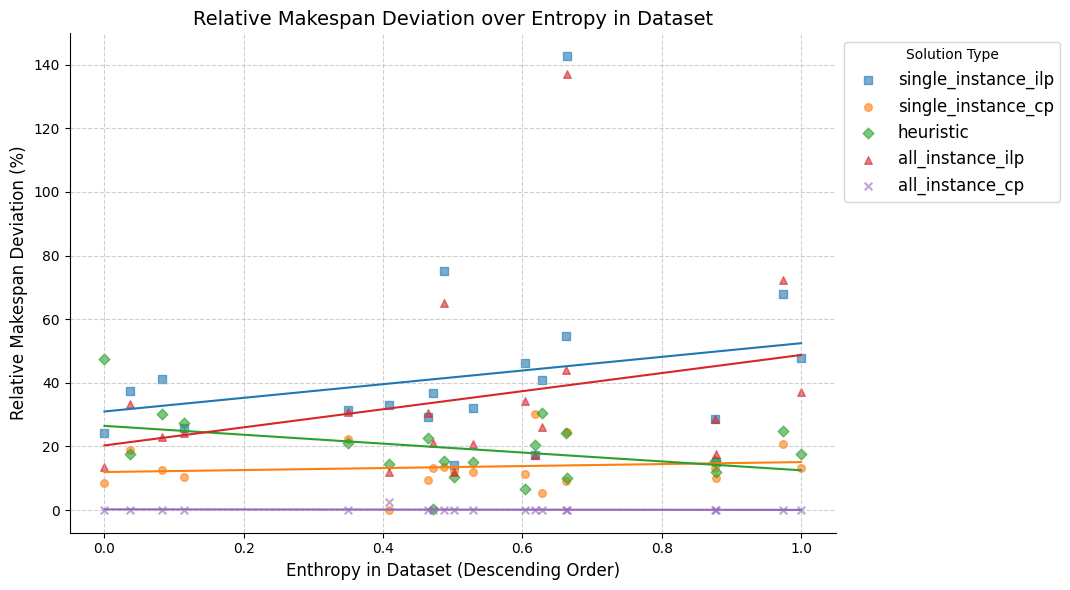

In [300]:
# Sort by normalized_entropy in descending order
visual_df = visual_df.sort_values(by='normalized_entropy_all', ascending=False)


marker_dict = {
    "all_instance_cp": "x",
    "single_instance_cp": "o",
    "heuristic": "D",
    "all_instance_ilp": "^",
    "single_instance_ilp": "s"
}

# Use sns.lmplot to create a scatterplot with trend lines for each solution_type
plot =sns.lmplot(
    data=visual_df,
    x="normalized_entropy_all",
    y="relative_makespan_deviation",
    hue="solution_type",
    markers=[marker_dict[s] for s in visual_df["solution_type"].unique()],
    scatter_kws={'s': 30, 'alpha': 0.6},  # Customize scatter points
    line_kws={'linewidth': 1.5},  # Customize trend line
    ci=None,  # Disable confidence intervals
    height=6,  # Size of the plot
    aspect=1.5,  # Aspect ratio
)

# Add labels and title
# Remove extra legends
plot._legend.remove()
plt.xlabel("Enthropy in Dataset (Descending Order)", fontsize=12)
plt.ylabel("Relative Makespan Deviation (%)", fontsize=12)
plt.title("Relative Makespan Deviation over Entropy in Dataset", fontsize=14)
plt.legend(title="Solution Type", fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


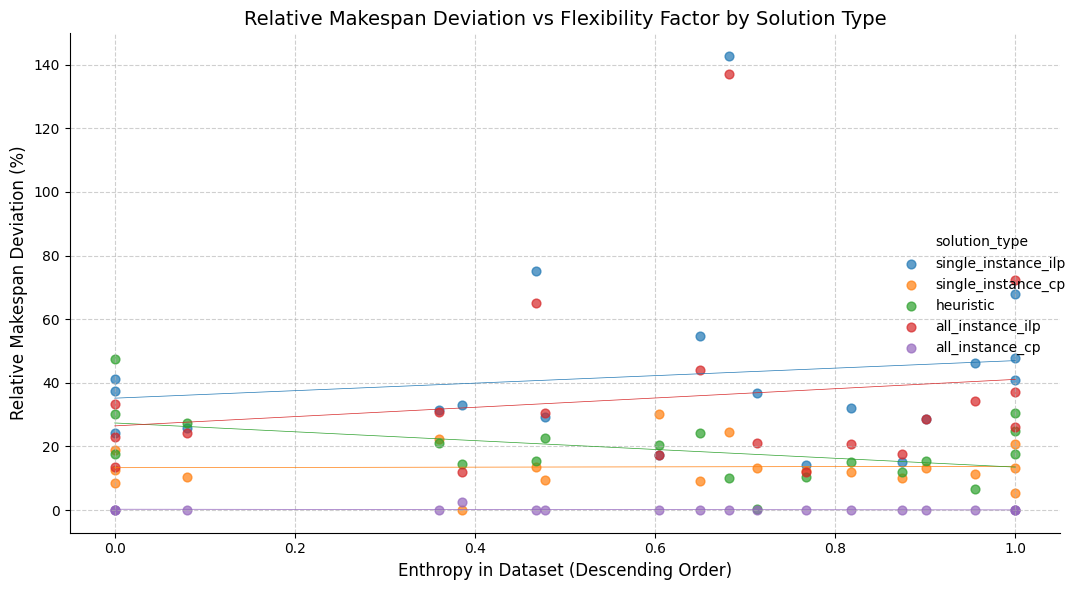

In [301]:
# Sort by normalized_entropy in descending order
visual_df = visual_df.sort_values(by='normalized_entropy', ascending=False)

# Use sns.lmplot to create a scatterplot with trend lines for each solution_type
sns.lmplot(
    data=visual_df,
    x="normalized_entropy",
    y="relative_makespan_deviation",
    hue="solution_type",
    scatter_kws={'s': 40, 'alpha': 0.7},  # Customize scatter points
    line_kws={'linewidth': 0.5},  # Customize trend line
    ci=None,  # Disable confidence intervals
    height=6,  # Size of the plot
    aspect=1.5  # Aspect ratio
)

# Add labels and title
plt.xlabel("Enthropy in Dataset (Descending Order)", fontsize=12)
plt.ylabel("Relative Makespan Deviation (%)", fontsize=12)
plt.title("Relative Makespan Deviation vs Flexibility Factor by Solution Type", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


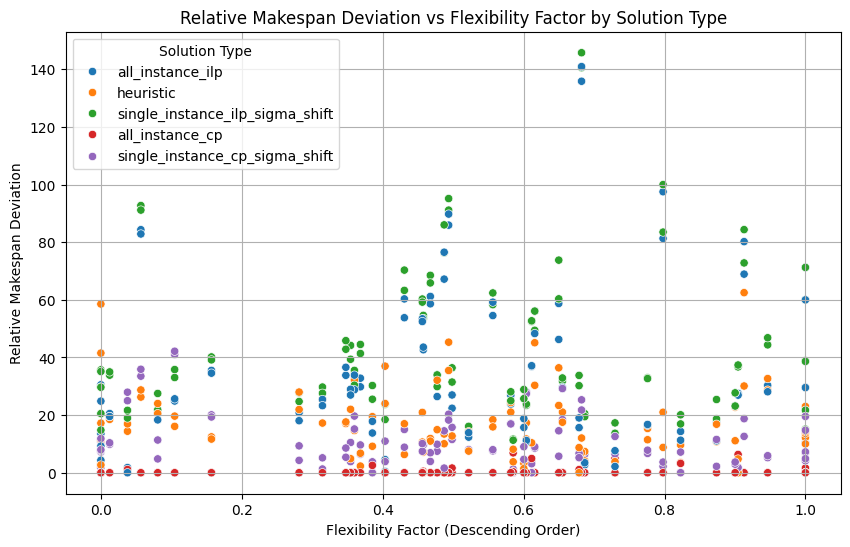

In [ ]:
# Sort by flex_factor in descending order
#visual_df
visual_df = visual_df.sort_values(by='normalized_entropy', ascending=False)

# Create the lineplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=visual_df,
    x="normalized_entropy",
    y="relative_makespan_deviation",
    hue="solution_type",
    marker="o"
)

# Add labels and title
plt.xlabel("Flexibility Factor (Descending Order)")
plt.ylabel("Relative Makespan Deviation")
plt.title("Relative Makespan Deviation vs Flexibility Factor by Solution Type")
plt.legend(title="Solution Type")
plt.grid(True)
plt.show()

In [ ]:
# concatenate eval_df1..4
dfs = [df.rename(columns={df.columns[0]: f"relative_makespan_deviation{suffix}"}) for df, suffix in zip([eval_df0, eval_df1, eval_df2, eval_df3, eval_df4], [suffix0, suffix1, suffix2, suffix3, suffix4])]
result = pd.concat(dfs, axis=1)
result

,relative_makespan_deviation_no_filter,relative_makespan_deviation_only_with_deletes,relative_makespan_deviation_early,relative_makespan_deviation_10_Tasks,relative_makespan_deviation_30_Tasks
solution_type,,,,,
all_instance_cp,0.000,0.000,0.000,0.000,0.000
single_instance_cp_sigma_shift,8.005,7.550,7.460,10.870,6.705
heuristic,14.530,17.015,15.150,24.625,10.920
all_instance_ilp,26.980,26.650,24.355,52.205,14.990
single_instance_ilp_sigma_shift,34.470,33.905,32.820,52.770,25.955


## Checks based on Arrival

In [302]:
objective_df = df[
    (df['release_type'] == 'arrival') &
    (df['config.cp_distribution_str'] != '1,0,0.0')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df5 = objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix5 = "differentiated_arrival"
objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,214.285714,50.571429,0.285714,0.180714
single_instance_cp,237.285714,227.142857,23.285714,11.209286
heuristic,257.285714,NaN,43.285714,21.452143
all_instance_ilp,270.428571,269.071429,56.428571,28.885714
single_instance_ilp,291.714286,291.714286,77.714286,36.791429


In [303]:
objective_df = df[
    (df['release_type'] == 'same_release') &
    (df['config.cp_distribution_str'] != '1,0,0.0')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df6 = objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix6 = "same_release_Tasks"
objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,


### Extra Checks


In [304]:

objective_df = df[['set_ident','solution_type', 'objective', 'min_objective']]
# Step 1: Get the min_objective for "all_instance_cp" for each set_ident
min_obj_cp = df[df["solution_type"] == "all_instance_cp"][["set_ident", "solution_type", "objective", "min_objective"]].reset_index()

# Step 2: Merge with the original dataframe to compare min_objective for each set_ident
df_merged = objective_df.join(min_obj_cp, on="set_ident", rsuffix=("_cp"))

# Step 3: Filter rows where the min_objective doesn't match the min_objective for "all_instance_cp"
filtered_df = df_merged[df_merged["min_objective"] != df_merged["objective_cp"]]

filtered_df

,set_ident,solution_type,objective,min_objective,index,set_ident_cp,solution_type_cp,objective_cp,min_objective_cp
index,,,,,,,,,
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,all_instance_cp,95.0,95.0,testsets_random_paper_smaller/10_generated/eva...,2.0,all_instance_cp,72.0,72.0
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,single_instance_cp,103.0,95.0,testsets_random_paper_smaller/10_generated/eva...,2.0,all_instance_cp,72.0,72.0
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,all_instance_ilp,108.0,95.0,testsets_random_paper_smaller/10_generated/eva...,2.0,all_instance_cp,72.0,72.0
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,single_instance_ilp,118.0,95.0,testsets_random_paper_smaller/10_generated/eva...,2.0,all_instance_cp,72.0,72.0
"testsets_random_paper_smaller/10_generated/evaluation/heuristic/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,heuristic,140.0,95.0,testsets_random_paper_smaller/10_generated/eva...,2.0,all_instance_cp,72.0,72.0
...,...,...,...,...,...,...,...,...,...
"testsets_random_paper_smaller/30_generated/evaluation/all_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json",20,all_instance_cp,589.0,589.0,NaN,NaN,NaN,NaN,NaN
"testsets_random_paper_smaller/30_generated/evaluation/heuristic/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json",20,heuristic,628.0,589.0,NaN,NaN,NaN,NaN,NaN
"testsets_random_paper_smaller/30_generated/evaluation/single_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json",20,single_instance_cp,655.0,589.0,NaN,NaN,NaN,NaN,NaN


In [305]:
objective_df
df_raw[df_raw['ilp_objective'].notna()][['ilp_objective', 'ilp_runtime']]

,ilp_objective,ilp_runtime
index,,
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",39.0,0.000518
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",39.0,0.000371
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-4-1-10.json",33.0,0.000455
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-4-1-10.json",33.0,0.000545
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_ilp/(0.8, 0.2, 0.0)-skill_short_branch-3-early-normal-4-1-10.json",50.0,0.000452
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_ilp/(0.8, 0.2, 0.0)-skill_short_branch-3-early-normal-4-1-10.json",50.0,0.000426
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_ilp/(0.8, 0.2, 0.0)-skill_short_branch-3-uniform-normal-4-1-10.json",34.0,0.000576
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_ilp/(0.8, 0.2, 0.0)-skill_short_branch-3-uniform-normal-4-1-10.json",34.0,0.000262
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_ilp/(1, 0, 0.0)-random-3-early-resource_based-3-1-10.json",61.0,0.000394


## Combined Solution

In [306]:
combined_solution_df

,objective,solver_status,lower_bound,optimality_gap,computing_time
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","[39, 47, 53, 64, 75, 86, 96, 103]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[39, 47, 53, 64, 75, 86, 96, 103]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.03, 0.06, 0.08, 0.05, 0.04, 0.06, 0.07, 0.06]"
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_cp/(1, 0, 0.0)-random-3-early-resource_based-3-1-10.json","[62, 76, 92, 111, 131, 151, 171, 191]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[62, 76, 92, 111, 131, 151, 171, 191]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.05, 0.09, 0.08, 0.11, 0.09, 0.11, 0.12, 0.11]"
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-4-1-10.json","[34, 41, 46, 54, 61, 69, 74, 87]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[34, 41, 46, 54, 61, 69, 74, 87]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.36, 0.49, 0.75, 2.16, 2.03, 0.41, 0.26, 0.49]"
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_cp/(0.8, 0.2, 0.0)-skill_short_branch-3-uniform-normal-4-1-10.json","[35, 42, 49, 58, 65, 74, 84, 95]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[35, 42, 49, 58, 65, 74, 84, 95]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.22, 0.35, 0.26, 0.65, 0.25, 0.23, 0.16, 0.26]"
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_cp/(0.8, 0.2, 0.0)-skill_short_branch-3-early-normal-4-1-10.json","[50, 64, 78, 92, 106, 121, 137, 150]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[50, 64, 78, 92, 106, 121, 137, 150]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.09, 0.2, 0.53, 0.25, 0.22, 0.4, 0.21, 0.25]"
...,...,...,...,...,...
"testsets_random_paper_smaller/20_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-normal-3-1-20.json","[90, 112, 138, 164, 190, 216, 252, 288]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[90, 112, 138, 164, 190, 216, 252, 288]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.02, 0.02, 0.03, 0.05, 0.02, 0.02, 0.02, 0.07]"
"testsets_random_paper_smaller/20_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-skill_short_branch-3-uniform-normal-4-1-20.json","[78, 93, 104, 129, 146, 213, 229, 244]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[78, 93, 104, 129, 146, 213, 229, 244]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.02, 0.03, 0.03, 0.04, 0.03, 0.02, 0.08, 0.1]"
"testsets_random_paper_smaller/20_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-random-3-early-normal-2-1-20.json","[75, 90, 119, 137, 165, 183, 211, 229]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[75, 90, 119, 137, 165, 183, 211, 229]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.02, 0.02, 0.02, 0.02, 0.04, 0.03, 0.03, 0.03]"
"testsets_random_paper_smaller/20_generated/evaluation/single_instance_ilp/(1, 0, 0.0)-skill_short_branch-3-early-resource_based-4-1-20.json","[137, 210, 285, 377, 450, 525, 617, 690]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[137, 210, 285, 377, 450, 525, 617, 690]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.01, 0.02, 0.02, 0.02, 0.03, 0.02, 0.02, 0.02]"


## Parallelity Evaluation

In [313]:
data = load_evaluation_files( root_path = "testsets_random_paper_smaller")
df, combined_solution_df = generate_pandas_df(data, online=True)
df = pre_process_df(df)
print(f"{len(data)} datasets loaded")

['10_generated', '30_generated', '20_generated']
100 datasets loaded


/tmp/ipykernel_1288658/2253014233.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shortened["min_objective"] = df_shortened.groupby("set_ident")["objective"].transform("min")


In [314]:
visual_df = df[['config_name', 'solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'res_std_dev', 'normalized_entropy', 'normalized_entropy_all', 'parallelity_norm']]
visual_df

,config_name,solution_type,objective,lower_bound,makespan_deviation,relative_makespan_deviation,res_std_dev,normalized_entropy,normalized_entropy_all,parallelity_norm
index,,,,,,,,,,
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",all_instance_cp,95.0,40.0,0.0,0.00,2.283451,0.000000,0.000000,0.287273
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",single_instance_cp,103.0,103.0,8.0,8.42,2.283451,0.000000,0.000000,0.287273
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",all_instance_ilp,108.0,108.0,13.0,13.68,2.283451,0.000000,0.000000,0.287273
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",single_instance_ilp,118.0,118.0,23.0,24.21,2.283451,0.000000,0.000000,0.287273
"testsets_random_paper_smaller/10_generated/evaluation/heuristic/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",heuristic,140.0,NaN,45.0,47.37,2.283451,0.000000,0.000000,0.287273
...,...,...,...,...,...,...,...,...,...,...
"testsets_random_paper_smaller/30_generated/evaluation/all_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","30_generated(1, 0, 0.0)-skill_short_branch-3-u...",all_instance_cp,589.0,61.0,0.0,0.00,3.427108,0.955017,0.604046,0.804371
"testsets_random_paper_smaller/30_generated/evaluation/heuristic/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","30_generated(1, 0, 0.0)-skill_short_branch-3-u...",heuristic,628.0,NaN,39.0,6.62,3.427108,0.955017,0.604046,0.804371
"testsets_random_paper_smaller/30_generated/evaluation/single_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","30_generated(1, 0, 0.0)-skill_short_branch-3-u...",single_instance_cp,655.0,561.0,66.0,11.21,3.427108,0.955017,0.604046,0.804371


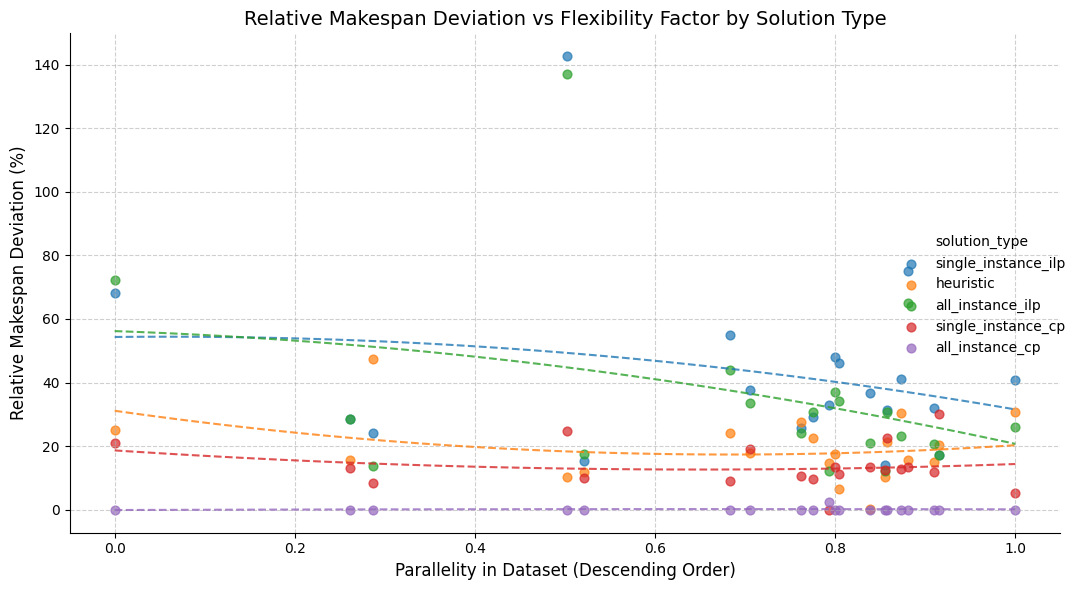

In [315]:
import numpy as np
# Sort by normalized_entropy in descending order
visual_df = visual_df.sort_values(by='parallelity_norm', ascending=False)

# Use sns.lmplot to create a scatterplot with trend lines for each solution_type
sns.lmplot(
    data=visual_df,
    x="parallelity_norm",
    y="relative_makespan_deviation",
    hue="solution_type",
    scatter_kws={'s': 40, 'alpha': 0.7},  # Customize scatter points
    line_kws={'linewidth': 2},  # Customize trend line
    ci=None,  # Disable confidence intervals
    height=6,  # Size of the plot
    aspect=1.5,  # Aspect ratio
    fit_reg=False
)

# Fit and plot non-linear trendlines
x_range = np.linspace(visual_df["parallelity_norm"].min(), visual_df["parallelity_norm"].max(), 100)

for solution in visual_df["solution_type"].unique():
    subset = visual_df[visual_df["solution_type"] == solution]
    if len(subset) < 3:
        continue  # Skip if not enough points for fitting
    
    # Fit a quadratic (2nd-degree) polynomial regression
    coefficients = np.polyfit(subset["parallelity_norm"], subset["relative_makespan_deviation"], deg=2)
    poly_model = np.poly1d(coefficients)
    
    # Plot the non-linear trendline
    plt.plot(x_range, poly_model(x_range), label=f"{solution} (trend)", linestyle="--", alpha=0.8)

# Add labels and title
plt.xlabel("Parallelity in Dataset (Descending Order)", fontsize=12)
plt.ylabel("Relative Makespan Deviation (%)", fontsize=12)
plt.title("Relative Makespan Deviation vs Flexibility Factor by Solution Type", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Multi Instance Evaluation


In [ ]:
data = load_evaluation_files( root_path = "testsets_random")
df, combined_solution_df = generate_pandas_df(data)
df = pre_process_df(df)
print(f"{len(data)} datasets loaded")

['10_instantArr', '10_generated', '30_instantArr', '30_generated', '20_instantArr', '20_generated']
500 datasets loaded


/tmp/ipykernel_685795/575386664.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shortened["min_objective"] = df_shortened.groupby("set_ident")["objective"].transform("min")


In [ ]:
df = df[['config_name', 'set_ident', 'parallelity', 'parallelity_norm', 'enthropy', 'normalized_entropy', 'normalized_entropy_all', 'solution_type',  'objective', 'makespan_deviation', 'relative_makespan_deviation', 'deviation_to_heur', 'flex_factor', 'res_std_dev', 'tasks', 'release_type', 'min_objective', 'lower_bound', 'solver status',  'total interval length', 'resources','config.cp_distribution','config.branch_distribution','config.resource_allocation_type', 'config.cost_allocation', 'release_times',]]
df = df.sort_values(by=["set_ident", "objective", "enthropy"])
df

,config_name,set_ident,parallelity,parallelity_norm,enthropy,normalized_entropy,normalized_entropy_all,solution_type,objective,makespan_deviation,...,min_objective,lower_bound,solver status,total interval length,resources,config.cp_distribution,config.branch_distribution,config.resource_allocation_type,config.cost_allocation,release_times
index,,,,,,,,,,,,,,,,,,,,,
"testsets_random/10_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.923077,0.384615,0.555786,0.000000,0.000000,all_instance_cp,118.0,0.0,...,118.0,51.0,Feasible,426.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[1, 10, 11, 12, 14, 14, 24, 28, 29, 31]"
"testsets_random/10_generated/evaluation/single_instance_cp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.923077,0.384615,0.555786,0.000000,0.000000,single_instance_cp_sigma_shift,132.0,14.0,...,118.0,132.0,Optimal,416.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[1, 10, 11, 12, 14, 14, 24, 28, 29, 31]"
"testsets_random/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.923077,0.384615,0.555786,0.000000,0.000000,all_instance_ilp,134.0,16.0,...,118.0,134.0,Optimal,390.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[1, 10, 11, 12, 14, 14, 24, 28, 29, 31]"
"testsets_random/10_generated/evaluation/single_instance_ilp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.923077,0.384615,0.555786,0.000000,0.000000,single_instance_ilp_sigma_shift,153.0,35.0,...,118.0,153.0,Optimal,390.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[1, 10, 11, 12, 14, 14, 24, 28, 29, 31]"
"testsets_random/10_generated/evaluation/heuristic/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.923077,0.384615,0.555786,0.000000,0.000000,heuristic,167.0,49.0,...,118.0,NaN,NaN,441.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[1, 10, 11, 12, 14, 14, 24, 28, 29, 31]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"testsets_random/30_instantArr/evaluation/all_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","30_instantArr(1, 0, 0.0)-skill_short_branch-3-...",101,1.000000,1.000000,0.991804,0.904411,0.604046,all_instance_cp,776.0,0.0,...,776.0,26.0,Feasible,2509.0,5,"[1, 0, 0.0]",uniform,skill_short_branch,resource_based,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
"testsets_random/30_instantArr/evaluation/single_instance_cp_sigma_shift/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","30_instantArr(1, 0, 0.0)-skill_short_branch-3-...",101,1.000000,1.000000,0.991804,0.904411,0.604046,single_instance_cp_sigma_shift,785.0,9.0,...,776.0,741.0,Feasible,2101.0,5,"[1, 0, 0.0]",uniform,skill_short_branch,resource_based,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
"testsets_random/30_instantArr/evaluation/heuristic/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","30_instantArr(1, 0, 0.0)-skill_short_branch-3-...",101,1.000000,1.000000,0.991804,0.904411,0.604046,heuristic,813.0,37.0,...,776.0,NaN,NaN,2269.0,5,"[1, 0, 0.0]",uniform,skill_short_branch,resource_based,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
objective_df = df
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'flex_factor', 'set_ident']]
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,flex_factor,set_ident
solution_type,,,,,,
all_instance_cp,272.0,51.0,0.0,0.000,2.0,51.5
single_instance_cp_sigma_shift,302.5,302.5,26.0,8.005,2.0,51.5
heuristic,303.0,NaN,35.5,14.530,2.0,51.5
all_instance_ilp,333.0,333.0,68.0,26.980,2.0,51.5
single_instance_ilp_sigma_shift,362.0,362.0,88.0,34.470,2.0,51.5
